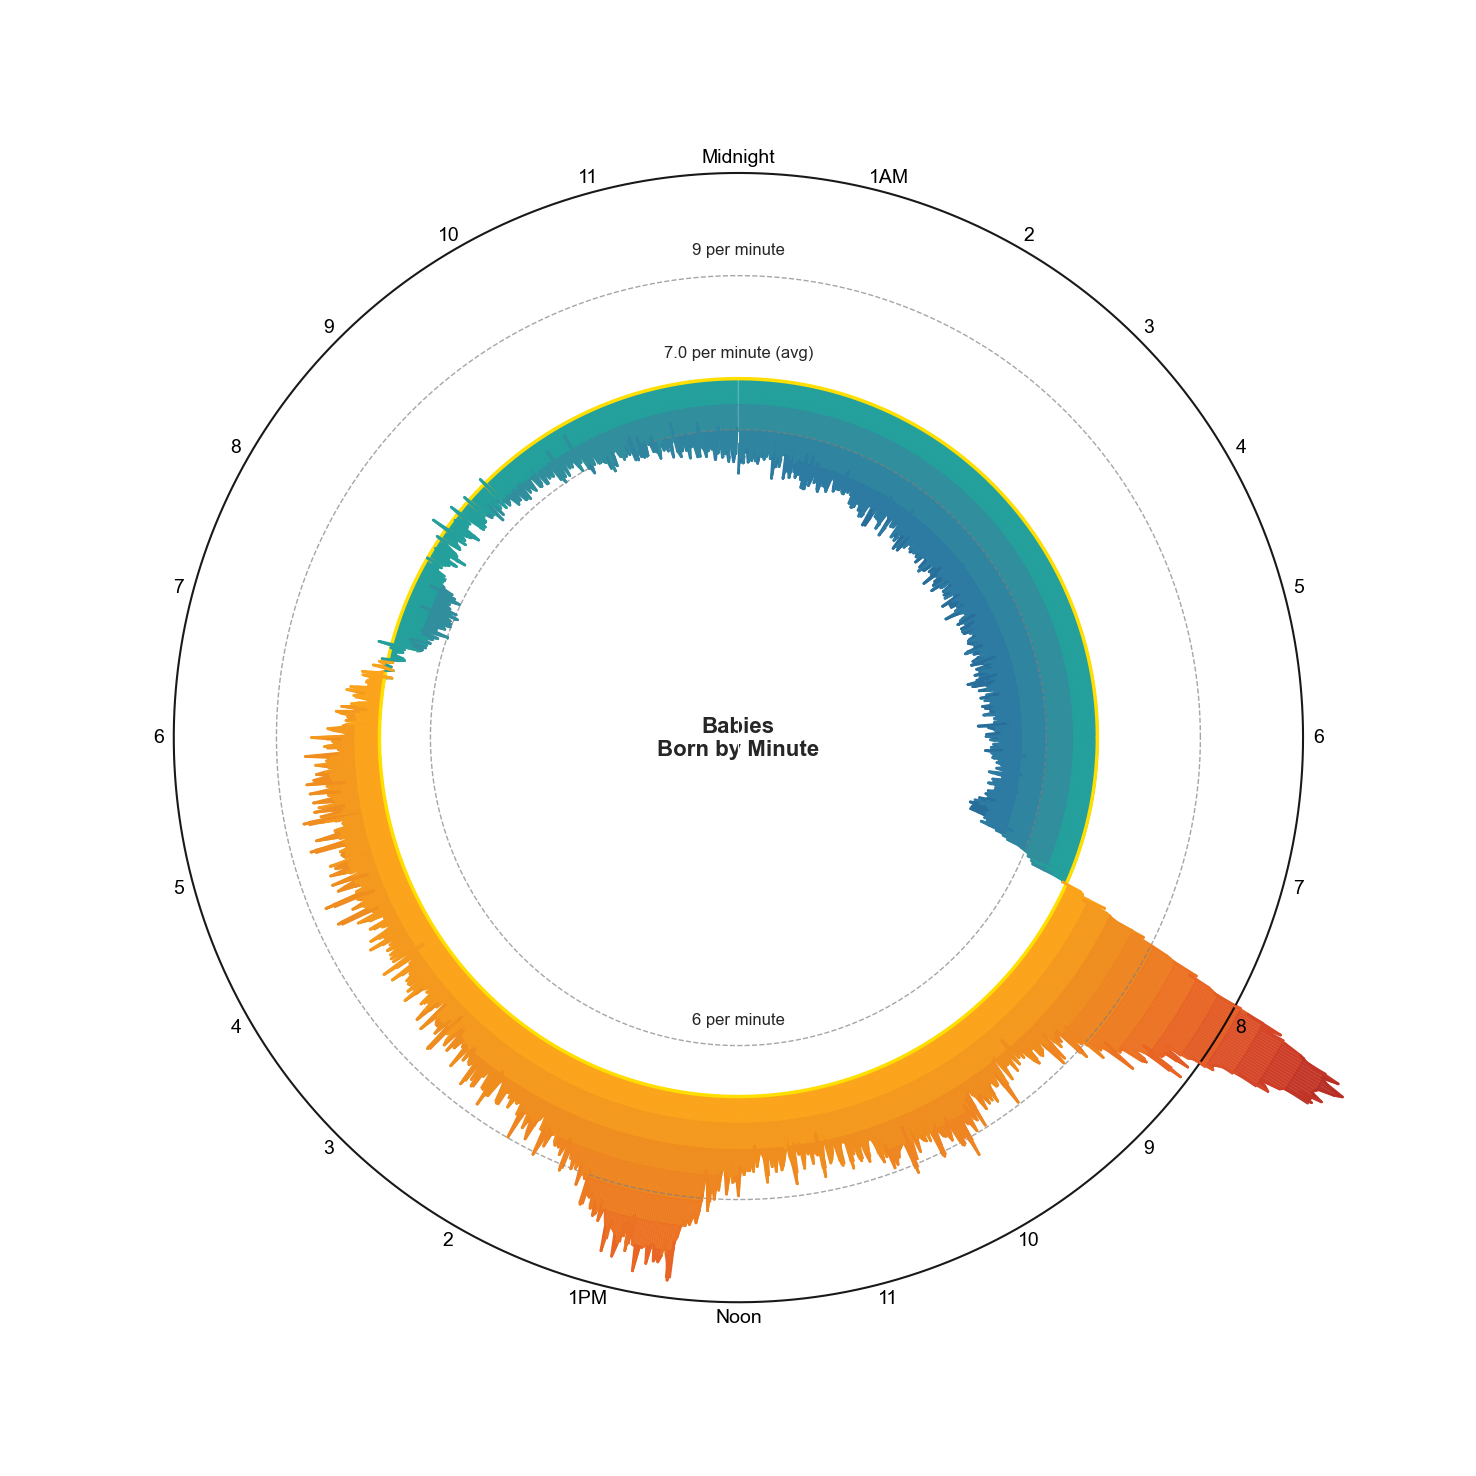

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


# Setting Seaborn style
sns.set_theme(style="white")
sns.set_context("notebook", font_scale=1.2)

# preparing data for visualisation
df = pd.read_csv('births.csv')
df['datetime'] = pd.to_datetime(df['time'], format='%H:%M')
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['minute_of_day'] = df['hour'] * 60 + df['minute']
births_per_minute = df.groupby('minute_of_day').size().reset_index(name='births')
total_births = births_per_minute['births'].sum()
minutes_per_year = 365 * 24 * 60
avg_births = total_births / minutes_per_year
births_per_minute['births'] = births_per_minute['births'] / 365
plt.figure(figsize=(15, 15), facecolor='white')
ax = plt.subplot(projection='polar', facecolor='white')
ax.grid(False)

#adjusting plots radial limit
theta = ((-births_per_minute['minute_of_day'] * 2 * np.pi / 1440) + np.pi/2) % (2 * np.pi)
r = births_per_minute['births']
max_r_value = max(r.max(), 11) + 0.5
ax.set_rlim(0, max_r_value)
theta_circle = np.linspace(0, 2*np.pi, 1000)



# color map
below_cmap = LinearSegmentedColormap.from_list('below_avg', [
    '#17B09C',  
    '#318F9D',
    '#2D7AA2',
    '#094E81',
    '#226192',
    '#2D7AA2',
    '#318F9D',
    '#17B09C'   
], N=100)


above_cmap = LinearSegmentedColormap.from_list('above_avg', [
    '#FBA41B',  
    '#EF901E',
    '#EE8320',
    '#EC7323',
    '#E66024',
    '#DB4F28',
    '#D03D26',
    '#BE3326',
    '#AD2A24'   
], N=100)



max_r_value = max(r.max(), 11)
below_range = avg_births
above_range = max_r_value - avg_births
proportion = above_range / below_range

# Below average levels
num_below_levels = 14
below_avg_levels = np.linspace(0, avg_births, num_below_levels + 1)
below_avg_colors = [below_cmap(i/num_below_levels) for i in range(num_below_levels)]


# Creating ring sizes that are equivalent between below and above average
num_above_levels = int(num_below_levels * proportion)
above_avg_levels = np.linspace(avg_births, max_r_value, num_above_levels + 1)
above_avg_colors = [above_cmap(i/num_above_levels) for i in range(num_above_levels)]



# For below-average values, creating filled areas OUTSIDE the data line
# Drawing levels from outermost to innermost to ensure all are visible
for i in range(num_below_levels-1, -1, -1):  
    lower_bound = below_avg_levels[i]
    upper_bound = below_avg_levels[i + 1]
    color = below_avg_colors[i]
    
    # Processing the entire circle at once for consistent ring appearance
    for j in range(len(theta) - 1):
        current_theta = [theta[j], theta[j+1]]
        current_r = r[j]
        next_r = r[j+1]
        
        # if at least one end of the segment is below upper_bound
        if current_r < upper_bound or next_r < upper_bound:
            # Calculating values at each end of the segment
            current_upper = upper_bound
            next_upper = upper_bound
            
            current_lower = max(current_r, lower_bound) if current_r < upper_bound else upper_bound
            next_lower = max(next_r, lower_bound) if next_r < upper_bound else upper_bound
            
            # plotting if there's a visible area
            if (current_upper > current_lower or next_upper > next_lower):
                ax.fill_between(
                    current_theta,
                    [current_lower, next_lower],
                    [current_upper, next_upper],
                    color=color,
                    alpha=0.9
                )

# For above-average values using the same approach
for i in range(num_above_levels):
    lower_bound = above_avg_levels[i]
    upper_bound = above_avg_levels[i + 1]
    color = above_avg_colors[i]
    
    for j in range(len(theta) - 1):
        current_theta = [theta[j], theta[j+1]]
        current_r = r[j]
        next_r = r[j+1]
        
        #if endpoints exceeds our lower bound
        if current_r > lower_bound or next_r > lower_bound:
            current_upper = min(current_r, upper_bound)
            next_upper = min(next_r, upper_bound)
            
            current_lower = max(current_r, lower_bound) if current_r < lower_bound else lower_bound
            next_lower = max(next_r, lower_bound) if next_r < lower_bound else lower_bound
            
            # Creating the fill between appropriate bounds
            if current_upper > current_lower or next_upper > next_lower:
                ax.fill_between(
                    current_theta,
                    [current_lower, next_lower],
                    [current_upper, next_upper],
                    color=color,
                    alpha=0.9
                )
    

# Drawing the line with matching colors instead of black
for j in range(len(theta) - 1):
    current_theta = [theta[j], theta[j+1]]
    current_r = r[j]
    next_r = r[j+1]
    avg_r = (current_r + next_r) / 2

    # Determining color based on whether point is above or below average
    if avg_r > avg_births:
        # For above average, finding which level it belongs to
        for i in range(num_above_levels):
            if avg_r >= above_avg_levels[i] and avg_r < above_avg_levels[i + 1]:
                line_color = above_avg_colors[i]
                break
        else:
            
            line_color = above_avg_colors[-1]
    else:
        # For below average, finding which level it belongs to
        for i in range(num_below_levels):
            if avg_r >= below_avg_levels[i] and avg_r < below_avg_levels[i + 1]:
                line_color = below_avg_colors[i]
                break
        else:
            
            line_color = below_avg_colors[0]
    
    # Drawing this segment with the matching color
    ax.plot(current_theta, [current_r, next_r], 
            color=line_color, 
            linewidth=2.0, 
            alpha=1.0,
            zorder=100)

# Plot reference circles
ax.plot(theta_circle, [avg_births] * len(theta_circle), color='#FFDE00', linestyle='-', linewidth=2.5, zorder=99)
ax.plot(theta_circle, [6] * len(theta_circle), color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.plot(theta_circle, [9] * len(theta_circle), color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.plot(theta_circle, [11] * len(theta_circle), color='black', linestyle='-', linewidth=1.5, alpha=0.9)

# Hide ticks and labels
ax.set_yticks([])  
ax.set_yticklabels([]) 
ax.set_xticklabels([])


# creating angle for time labels
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False)
r_label = 11.3  # Slightly outside the outermost circle
hours = ['6', '5', '4', '3', '2', '1AM', 'Midnight', '11', '10', '9', '8', '7',
         '6', '5', '4', '3', '2', '1PM', 'Noon', '11', '10', '9', '8', '7']

# Adding time labels manually
for angle, label in zip(angles, hours):
    ax.text(angle, r_label, label, fontsize=14, ha='center', va='center',
             color='black')


# Adding title and annotations
ax.text(0, 0, 'Babies\nBorn by Minute', ha='center', va='center', 
        fontsize=16, fontweight='bold')

ax.annotate('9 per minute', xy=(np.pi/2, 9), xytext=(np.pi/2, 9.5),
            arrowprops=dict(arrowstyle='-', linewidth=0.8), 
            ha='center', va='center', fontsize=12)

ax.annotate(f'{avg_births:.1f} per minute (avg)', xy=(np.pi/2, avg_births), 
            xytext=(np.pi/2, avg_births+0.5),
            arrowprops=dict(arrowstyle='-', linewidth=0.8), 
            ha='center', va='center', fontsize=12)

ax.annotate('6 per minute', xy=(np.pi/2, 6), xytext=(-np.pi/2, 5.5),
            arrowprops=dict(arrowstyle='-', linewidth=0.8), 
            ha='center', va='center', fontsize=12)

ax.spines['polar'].set_visible(False)
  
plt.savefig("radial_design.png")
plt.tight_layout()